# [과제 2] 회귀분석
### - Ch 1, Ch 2를 토대로 자유롭게 회귀분석과 회귀진단을 진행해주세요.
### - 주석으로 설명 및 근거 자세하게 달아주시면 감사하겠습니다. :)

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

# Data 

데이터 출처 : https://www.kaggle.com/avikasliwal/used-cars-price-prediction 

< y > 
* **Price** : The price of the used car in INR Lakhs.



< X > 
* Name : The brand and model of the car
* Location : The location in which the car is being sold or is available for purchase.
* Year : The year or edition of the model.
* Kilometers_Driven : The total kilometres driven in the car by the previous owner(s) in KM.
* Fuel_Type : The type of fuel used by the car. (Petrol, Diesel, Electric, CNG, LPG)
* Transmission : The type of transmission used by the car. (Automatic / Manual)
* Owner_Type : Whether the ownership is Firsthand, Second hand or other.
* Mileage : The standard mileage offered by the car company in kmpl or km/kg
* Engine : The displacement volume of the engine in CC.
* Power : The maximum power of the engine in bhp.
* Seats : The number of seats in the car.
* New_Price : The price of a new car of the same model.

In [2]:
# Load Data 
data = pd.read_csv("assignment2_data.csv")
data.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


In [4]:
data.isnull().sum()

Unnamed: 0              0
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

### 전처리

#### 제거
Unnamed: 0 와 이름은 회귀에 불필요하므로 제거    
이상치가 전체 데이터의 약 86% 이상을 차지하는 New_Price 제거

In [5]:
data.drop(['Unnamed: 0', 'Name', 'New_Price'], axis=1, inplace=True)

#### 단위 제거 및 수치형으로 변환
Mileage, Engine, Power는 수치형 변수이지만 단위가 붙어 object형으로 인식됨. 처리 필요

In [6]:
# 문자열에서 숫자만 추출 후 astype으로 수치형변환
data['Mileage'] = data['Mileage'].str.extract(r'(\d+.\d+)', expand = False).astype(float)
data['Engine'] = data['Engine'].str.extract(r'(\d+.\d+)', expand = False).astype(float)
data['Power'] = data['Power'].str.extract(r'(\d+.\d+)', expand = False).astype(float)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Location           6019 non-null   object 
 1   Year               6019 non-null   int64  
 2   Kilometers_Driven  6019 non-null   int64  
 3   Fuel_Type          6019 non-null   object 
 4   Transmission       6019 non-null   object 
 5   Owner_Type         6019 non-null   object 
 6   Mileage            6017 non-null   float64
 7   Engine             5982 non-null   float64
 8   Power              4915 non-null   float64
 9   Seats              5977 non-null   float64
 10  Price              6019 non-null   float64
dtypes: float64(5), int64(2), object(4)
memory usage: 517.4+ KB


In [10]:
df = data.copy()

#### 이상치 확인

In [11]:
data.select_dtypes(include = ['int64', 'float64']).columns

Index(['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats',
       'Price'],
      dtype='object')

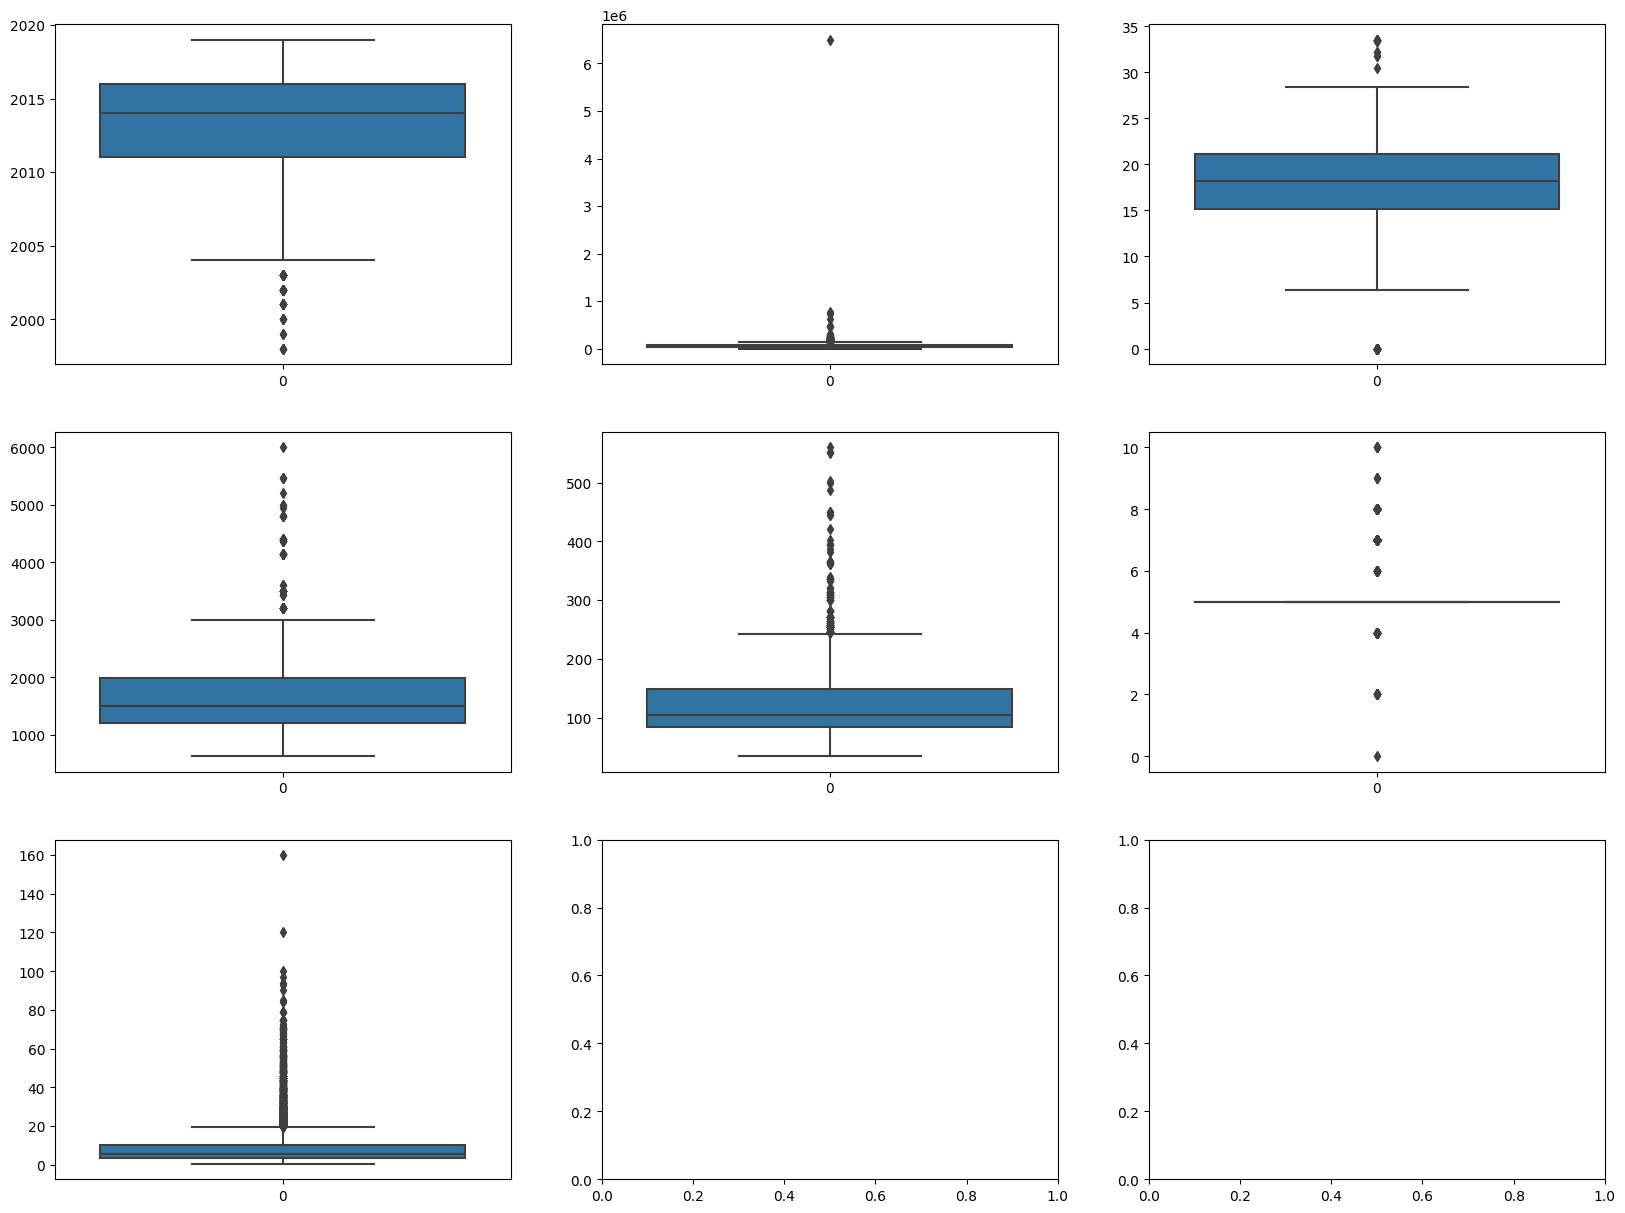

In [12]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20,15))

sns.boxplot(data['Year'], ax=ax[0,0])
sns.boxplot(data['Kilometers_Driven'], ax=ax[0,1])
sns.boxplot(data['Mileage'], ax=ax[0,2])
sns.boxplot(data['Engine'], ax=ax[1,0])
sns.boxplot(data['Power'], ax=ax[1,1])
sns.boxplot(data['Seats'], ax=ax[1,2])
sns.boxplot(data['Price'], ax=ax[2,0])

plt.show()

#### 결측치 처리

In [13]:
data.isnull().sum()

Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 37
Power                1104
Seats                  42
Price                   0
dtype: int64

In [14]:
data = data.fillna(data.mean())

#### 수치형 변수 분포 확인

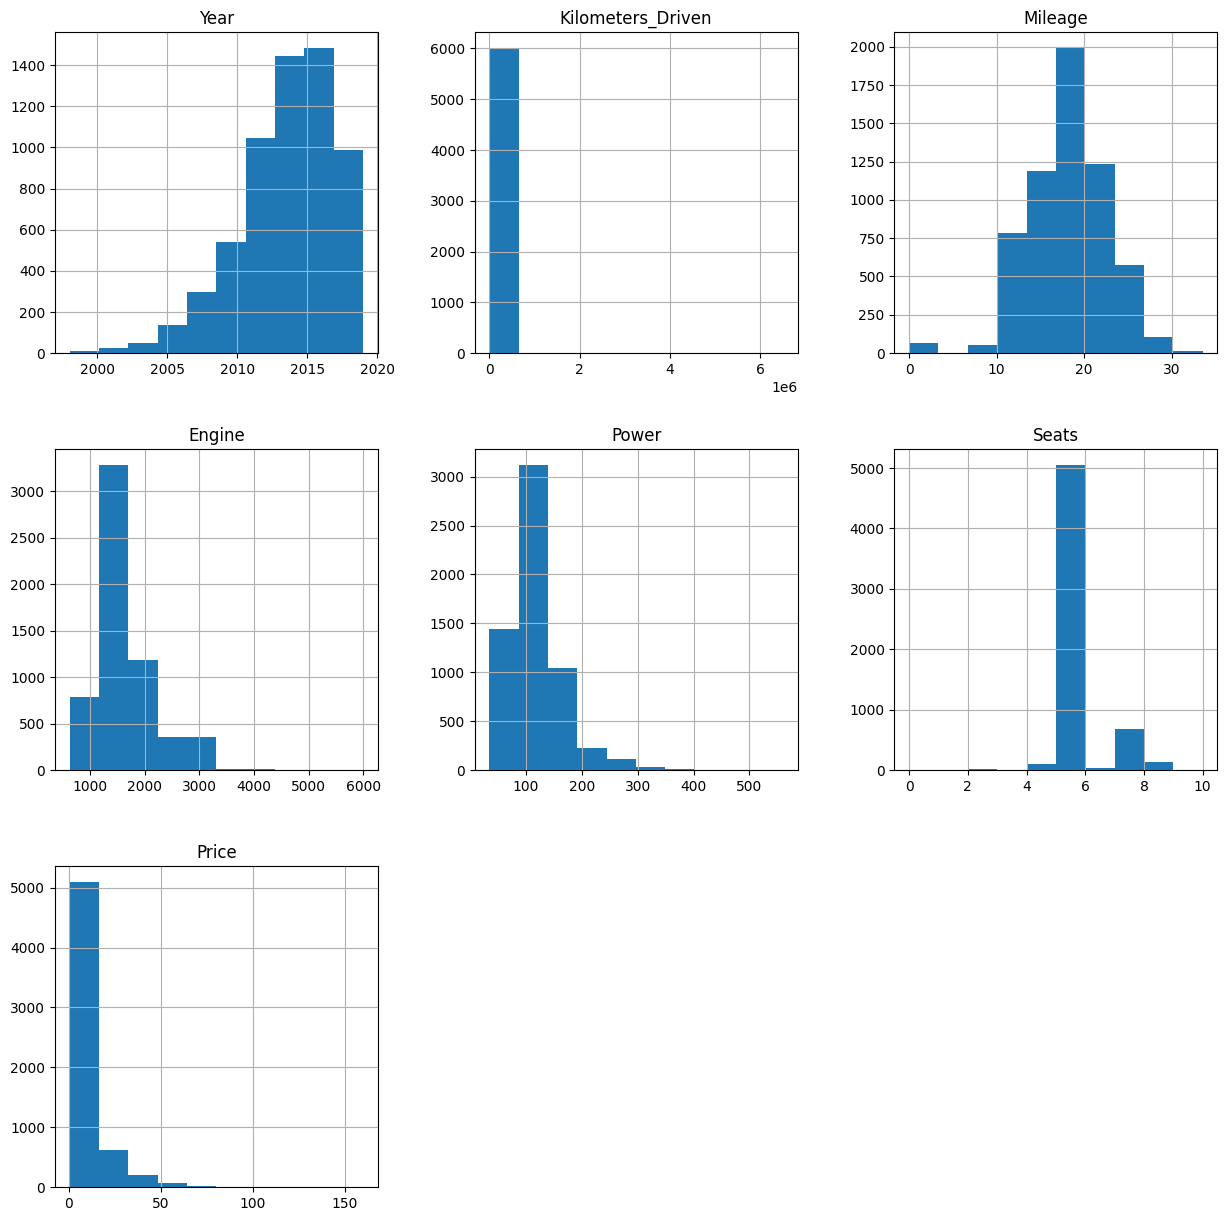

In [15]:
data.hist(figsize=(15,15))
plt.show()

In [16]:
# 한쪽으로 치우쳐져 있는 분포를 갖고, 단위가 다르므로 표준화 필요

#### 범주형 변수 시각화 및 가변수 변환

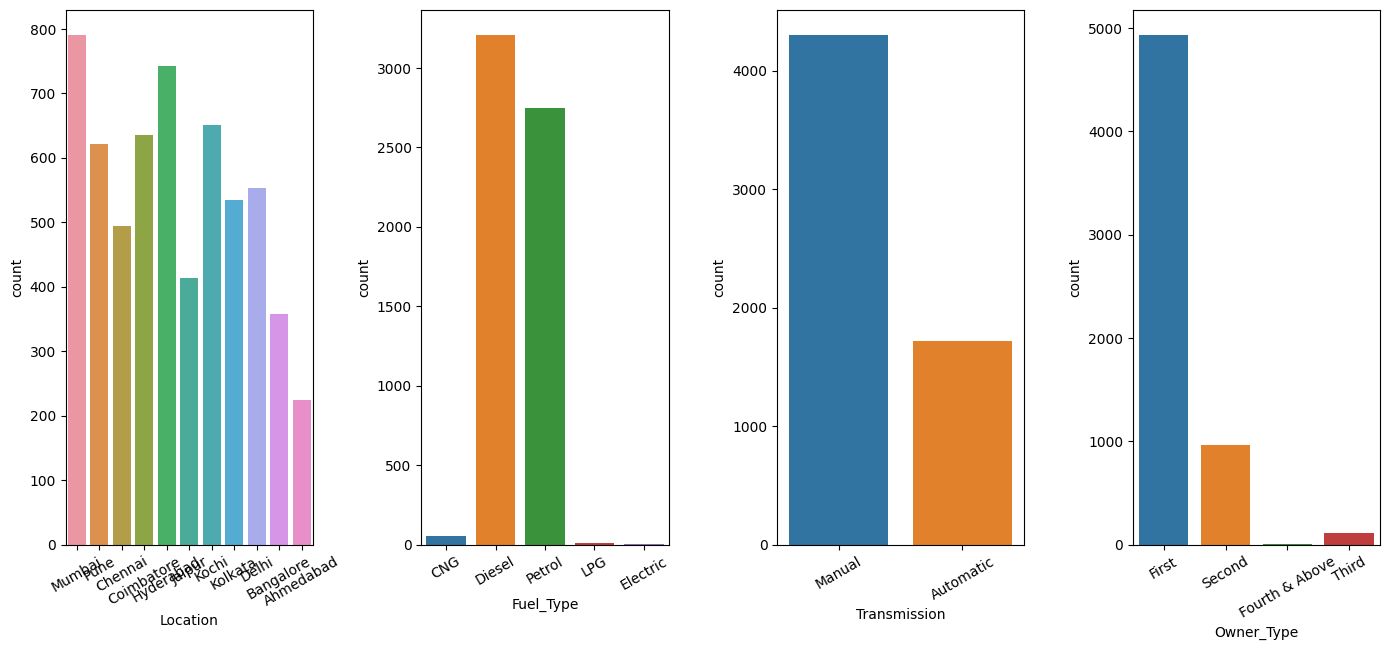

In [17]:
obj_col = data.select_dtypes(include = 'object')

plt.figure(figsize=(14,25))
for i,col in enumerate(obj_col):
    axes = plt.subplot(4,4, i + 1)
    sns.countplot(x=data[col])
    plt.xticks(rotation = 30)
plt.tight_layout()
plt.show()  

#### 수치형 변수 scailing

In [18]:
X = data.drop(["Price"], axis=1)
y = data.Price

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 0)

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# 숫자형만 추출
X_train_numeric = X_train.select_dtypes(include = ['int64', 'float64'])
X_train_numeric = pd.DataFrame(scaler.fit_transform(X_train_numeric), columns = X_train_numeric.columns)
X_train_numeric.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats
0,0.190725,0.023837,-0.257986,-0.707386,-0.855151,-0.338100
1,0.190725,-0.131930,0.649149,-1.356062,-1.341079,-0.338100
2,1.096335,-0.259155,0.824018,-0.197591,-0.451237,2.177527
3,1.398205,-0.181097,0.168258,-0.707386,-0.794461,-0.338100
4,-0.714885,0.270232,-1.405567,1.252191,1.168522,-0.338100


In [20]:
# 검증데이터
X_test_numeric = X_test.select_dtypes(include = ['int64', 'float64'])
X_test_numeric = pd.DataFrame(scaler.transform(X_test_numeric), columns = X_test_numeric.columns)
X_test_numeric.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats
0,0.190725,0.028507,-0.662372,0.955799,0.397599,2.177527
1,-1.016755,0.265533,-0.072188,-0.621009,0.006034,-0.338100
2,-0.413015,0.078786,-0.675487,-0.028224,-0.348720,-0.338100
3,-0.413015,-0.127744,-1.471143,2.266700,0.681774,2.177527
4,1.096335,-0.288452,-1.123590,1.489305,-0.410230,3.435340


#### 범주형 변수 가변수 변환

In [21]:
X_train = pd.get_dummies(X_train, dtype=np.int64).reset_index()
X_test = pd.get_dummies(X_test, dtype=np.int64).reset_index()

In [22]:
# 범주형 변수와 수치형 변수 합치기
X_train = pd.concat([X_train_numeric, X_train.iloc[:,6:]], axis=1)
X_test = pd.concat([X_test_numeric, X_test.iloc[:,6:]], axis=1)

### 선형회귀분석

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4514, 29), (1505, 29), (4514,), (1505,))

In [24]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

pred = model.predict(X_test)

In [25]:
#MSE
from sklearn.metrics import mean_squared_error 
mean_squared_error(y_test, pred)

36.18948725498339

In [26]:
#R-squared
from sklearn.metrics import r2_score
print(r2_score(y_test, pred))

0.7104499932490667


### 회귀진단

In [33]:
# 전체 데이터에 대한 scailing
df_numeric = df.select_dtypes(include = ['int64', 'float64'])
df_scailing = pd.DataFrame(scaler.transform(df_numeric), columns = df_numeric.columns)

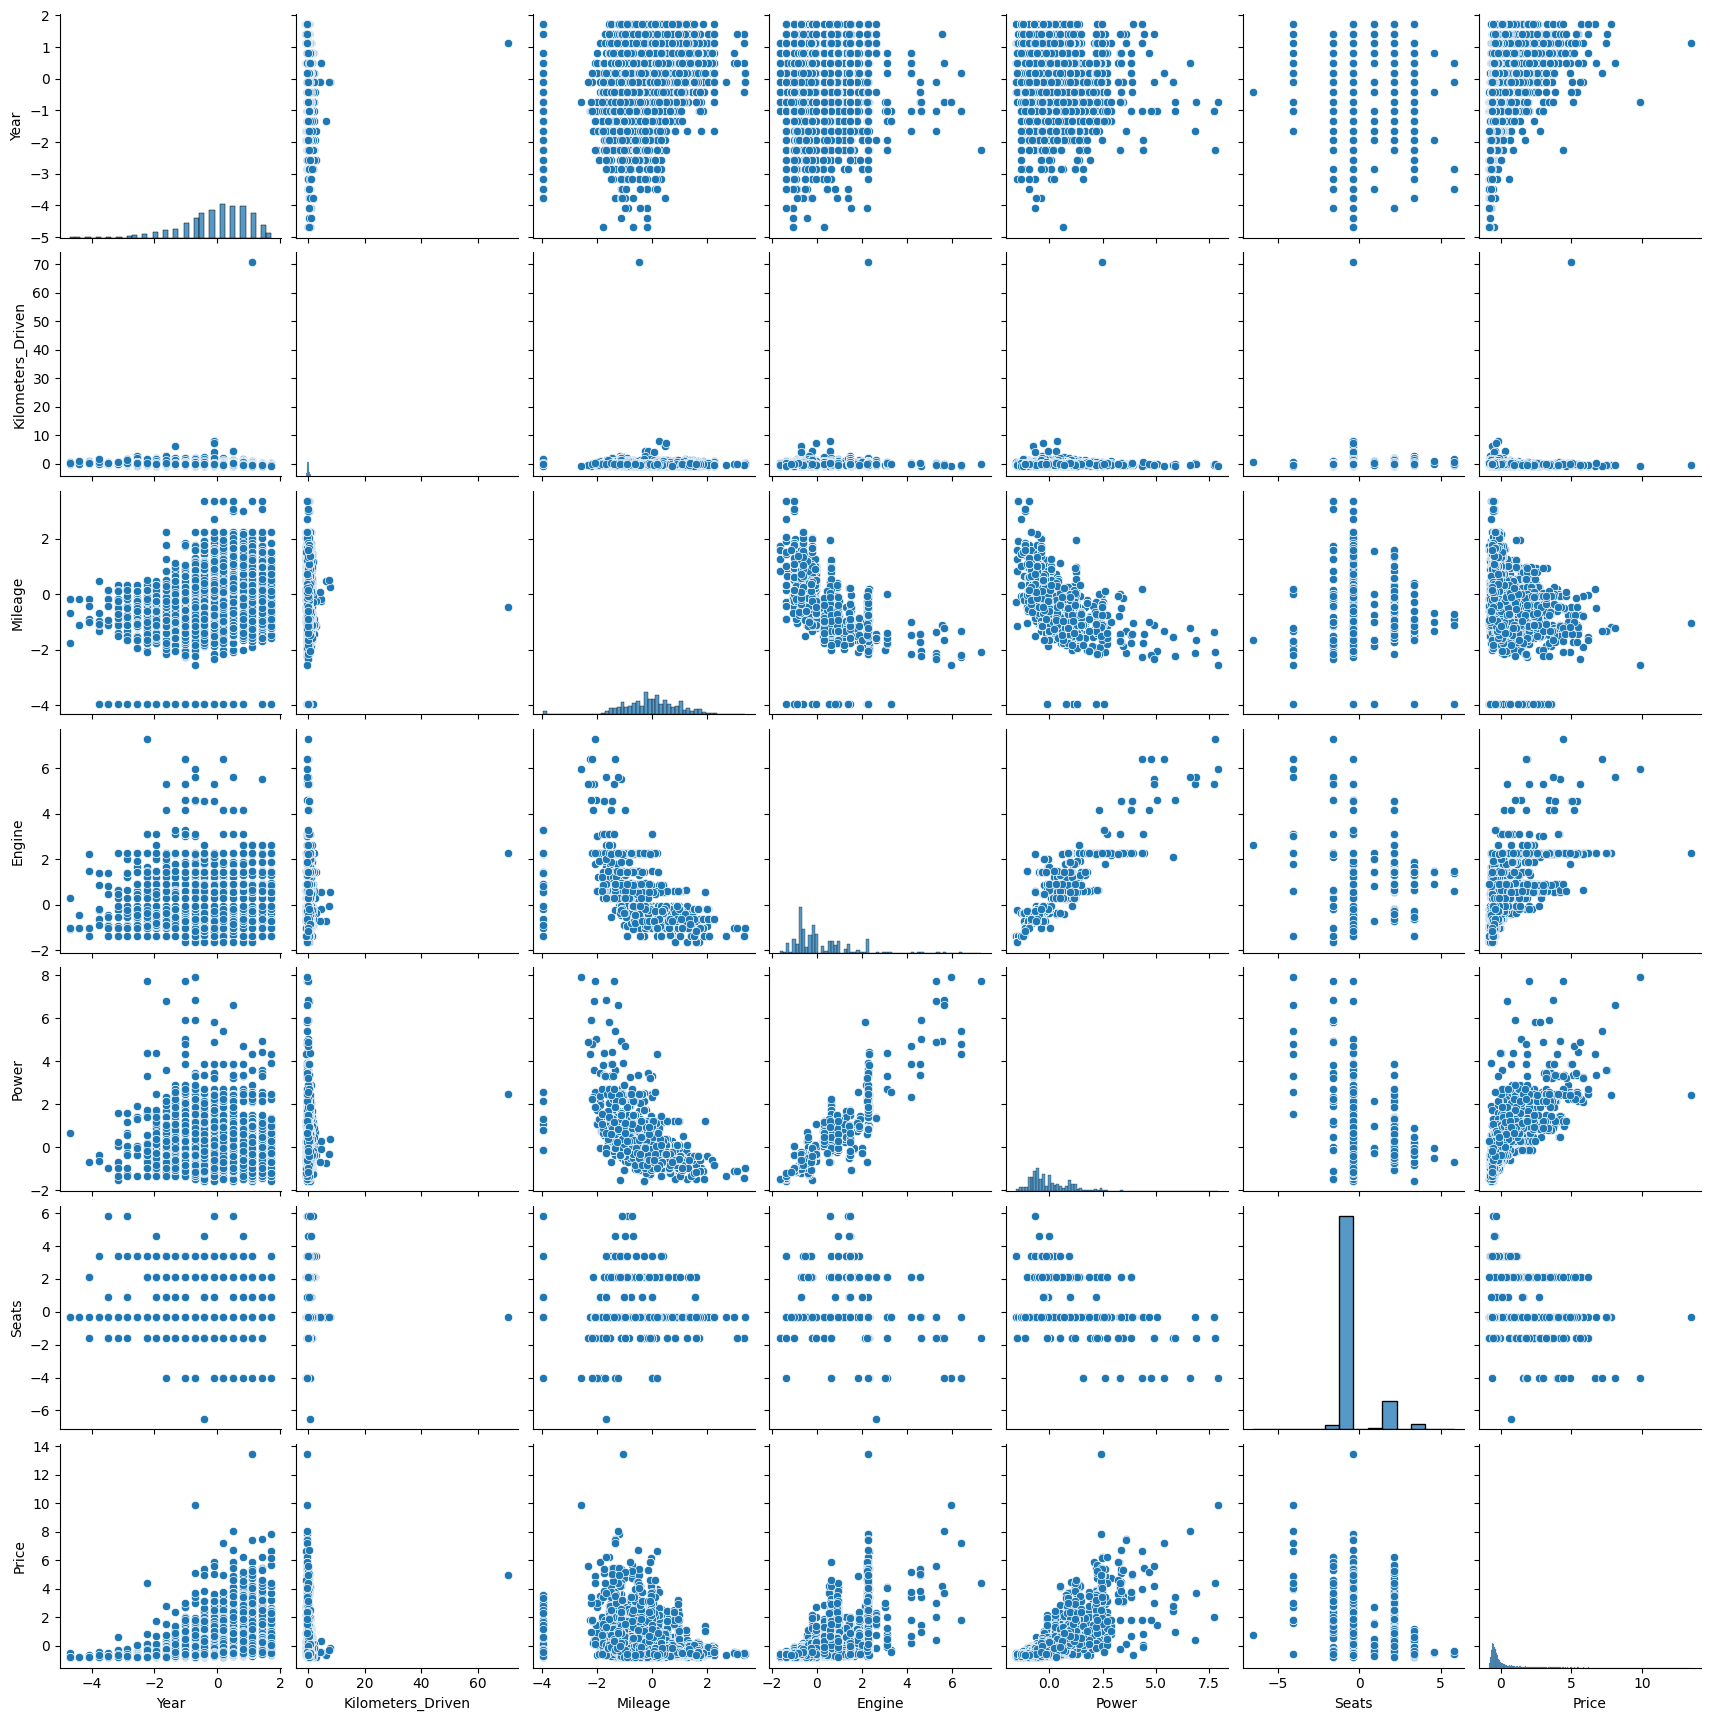

In [34]:
# 선형성
sns.pairplot(df_scailing)

Price와 모든 설명변수 사이에는 선형관계가 있다고 보기 어렵다.

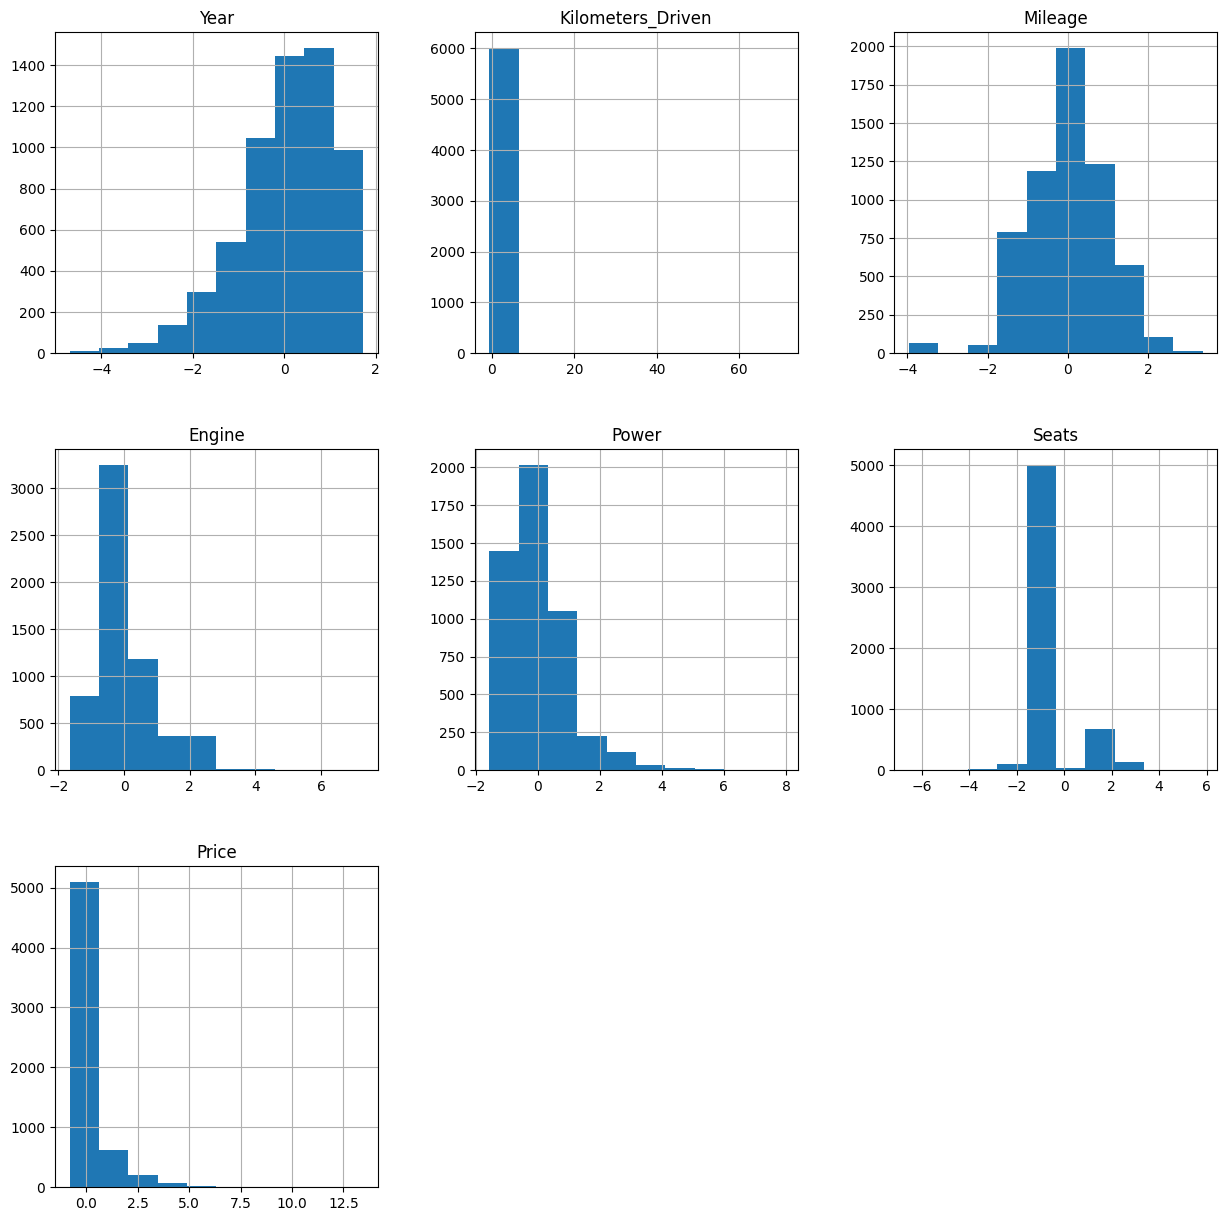

In [39]:
# 정규성
df_scailing.hist(figsize=(15,15))
plt.show()

Year, Engine, Power는 정규성 가정을 위배한다고 볼 수 있음

### 유의변수 추출

In [47]:
import statsmodels.api as sm

model = sm.OLS(list(y_train), sm.add_constant(X_train))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     413.3
Date:                Wed, 02 Aug 2023   Prob (F-statistic):               0.00
Time:                        09:33:22   Log-Likelihood:                -14674.
No. Observations:                4514   AIC:                         2.940e+04
Df Residuals:                    4489   BIC:                         2.956e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

p-value가 0.05보다 작은 변수를 유의변수라고 정의.    
0.05보다 큰 변수 제외

In [48]:
X_train.drop(['Kilometers_Driven','Location_Ahmedabad','Location_Chennai','Location_Jaipur','Location_Pune',
              'Fuel_Type_CNG','Fuel_Type_Diesel','Fuel_Type_Electric','Fuel_Type_LPG','Fuel_Type_Petrol','Owner_Type_First',
              'Owner_Type_Fourth & Above','Owner_Type_Second','Owner_Type_Third'], axis=1, inplace=True)

In [49]:
X_test.drop(['Kilometers_Driven','Location_Ahmedabad','Location_Chennai','Location_Jaipur','Location_Pune',
              'Fuel_Type_CNG','Fuel_Type_Diesel','Fuel_Type_Electric','Fuel_Type_LPG','Fuel_Type_Petrol','Owner_Type_First',
              'Owner_Type_Fourth & Above','Owner_Type_Second','Owner_Type_Third'], axis=1, inplace=True)

### 추가적인 선형회귀분석

In [53]:
from sklearn.linear_model import Lasso, Ridge

In [54]:
# 라쏘
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

pred = lasso.predict(X_test)

print(lasso.intercept_ , lasso.coef_ )

8.44434947394933 [ 3.54517655 -0.          3.03956742  4.88515458 -0.8942782  -0.
  0.31480603  0.60855884 -0.          0.70867947 -0.         -0.26196809
 -0.39571888  3.00974583 -0.        ]


In [55]:
#MSE
from sklearn.metrics import mean_squared_error 
mean_squared_error(y_test, pred)

36.64356258792797

In [56]:
#R-squared
from sklearn.metrics import r2_score
print(r2_score(y_test, pred))

0.7068169626180115


In [67]:
# 릿지
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)

pred = ridge.predict(X_test)

print(ridge.intercept_ , ridge.coef_ )

12.91924651057251 [ 3.69659128 -0.13500257  3.15422292  4.67922147 -0.66239088 -0.52662092
  1.88261311  1.3463059  -0.82540862  1.44893707 -0.66021191 -1.41845522
 -1.31948332  1.70667397 -1.70667397]


In [68]:
#MSE
from sklearn.metrics import mean_squared_error 
mean_squared_error(y_test, pred)

36.67694209030897

In [69]:
#R-squared
from sklearn.metrics import r2_score
print(r2_score(y_test, pred))

0.7065498951386724


선형회귀와 라쏘, 릿지 모두 비슷한 성능을 가짐